In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import pylab
import tensorflow as tf
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
# Form dataset matrix
def create_dataset(dataset, previous=1):
	dataX, dataY = [], []
	for i in range(dataset.shape[0]-previous-1):
		a = dataset[i:(i+previous), :]
		dataX.append(a)
		dataY.append(dataset[i + previous, :])
	return np.array(dataX), np.array(dataY)

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

# load dataset
df = read_csv('dccelectricitycivicsblocks34p20130221-1840.csv', engine='python', skipfooter=3)
df

,Civic Offices Blocks 3 and 4 KWh,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97
0,Date,Values,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
1,29/03/2011,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.80000305,31.20000076,31.65000153,30.60000038,32.85000229,31.05000305,32.10000229,31.35000229,31.65000153,30.15000153
2,30/03/2011,96,32.10000229,32.40000153,33.60000229,33,29.70000076,30.90000153,31.50000191,33,...,35.70000076,33.60000229,34.20000076,34.80000305,34.65000153,33.75,33.15000153,32.70000076,31.50000191,33.60000229
3,31/03/2011,96,32.10000229,33.60000229,35.10000229,33.45000076,31.20000076,31.35000038,34.20000076,33.75,...,33,33,35.25,34.35000229,32.40000153,31.20000076,32.84999847,33.45000076,32.10000229,32.10000229
4,01/04/2011,96,32.70000076,34.5,30.30000305,33,33,31.5,30.30000305,32.84999847,...,32.25,33.45000076,33,30.45000076,33.15000153,30.60000229,30.15000153,32.55000305,33,30.15000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,13/02/2013,96,25,25,25.5,24.5,25,26,25.5,25.5,...,33,32.5,30.5,27.5,26,26,26,26,25.5,26.5
689,14/02/2013,96,26,25.5,26,25.5,25,27,25.5,26.5,...,31,30,30.5,29,28,26.5,25.5,25,25.5,25
690,15/02/2013,96,25.5,24.5,25.5,24.5,25,26.5,25,25.5,...,29,27,28,28,25.5,26,25.5,25.5,24.5,25
691,16/02/2013,96,25,25,24.5,24.5,24.5,26.5,25,25.5,...,24.5,24,24.5,26,24.5,24,25,24.5,25,24


In [4]:
df2=df.rename(columns=df.iloc[0])
df3=df2.drop(df.index[0])
df3
df3.drop(df3.index[0])
df4=df3.drop('Date', axis=1)
df5=df4.drop('Values', axis=1)
df5
df6=df5.dropna()
df7=df6.values
df7
df7.shape
dataset=np.array(df7,dtype=float)#np.sum(df7, axis=1, dtype=float)
#dataset
dataset.shape

(680, 96)

In [5]:
# meankwh=np.mean(dataset)
print (dataset)
dataset=dataset.reshape((-1,96))

# normalize dataset with MinMaxScaler
#dataset=np.log(dataset)
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)
#dataset

[[32.10000229 32.40000153 33.60000229 ... 32.70000076 31.50000191
  33.60000229]
 [32.10000229 33.60000229 35.10000229 ... 33.45000076 32.10000229
  32.10000229]
 [31.80000114 32.40000153 30.45000076 ... 31.5        33.45000076
  32.55000305]
 ...
 [25.5        24.5        25.5        ... 25.5        24.5
  25.        ]
 [25.         25.         24.5        ... 24.5        25.
  24.        ]
 [24.5        24.         24.         ... 25.         25.
  25.        ]]


In [15]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import os
#dataset=dataset.reshape(-1,1)
#print (dataset.shape)
# Training and Test data partition
train_size = int(dataset.shape[0] * 0.8)
test_size = dataset.shape[0] - train_size
train, test = dataset[0:train_size,:1], dataset[train_size:dataset.shape[0],:1]
print(train.shape)
print(test.shape)

# reshape into X=t-50 and Y=t (MODIFY TIME HERE)
previous = 50
X_train, Y_train = create_dataset(train, previous)
X_test, Y_test = create_dataset(test, previous)
X_train = X_train.reshape(X_train.shape[0],-1)
Y_train = Y_train.reshape(Y_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
Y_test = Y_test.reshape(Y_test.shape[0],-1)
print (X_train.shape)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print (X_train.shape)
print (Y_train)
# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1,X_train.shape[2])))
model.add(Dense(Y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=1500, batch_size=10, verbose=1)
model.save(os.path.join('./model','lstm.h5'))

(544, 1)
(136, 1)
(493, 50)
(493, 1, 50)
[[30.14999962]
 [32.10000229]
 [30.75      ]
 [33.59999847]
 [32.40000153]
 [32.70000076]
 [31.95000076]
 [29.85000038]
 [32.10000229]
 [33.75000381]
 [37.05000305]
 [34.20000076]
 [34.65000153]
 [31.05000114]
 [31.05000114]
 [31.65000153]
 [32.85000229]
 [36.90000153]
 [32.40000153]
 [30.45000076]
 [33.        ]
 [35.25      ]
 [34.80000305]
 [37.05000305]
 [36.        ]
 [32.54999924]
 [32.40000153]
 [28.5       ]
 [34.05000305]
 [32.85000229]
 [33.45000076]
 [33.        ]
 [30.30000114]
 [29.55000114]
 [31.04999924]
 [33.30000305]
 [33.15000153]
 [31.79999924]
 [33.60000229]
 [29.85000229]
 [30.29999924]
 [34.65000153]
 [34.20000076]
 [31.20000076]
 [32.55000305]
 [32.25      ]
 [31.20000076]
 [30.60000038]
 [30.90000153]
 [33.45000076]
 [39.        ]
 [35.40000153]
 [32.40000153]
 [31.05000305]
 [31.80000114]
 [33.45000076]
 [35.25      ]
 [37.95000076]
 [33.60000229]
 [33.60000229]
 [31.65000153]
 [32.10000229]
 [34.34999847]
 [34.80000305]

493/493 [==============================] - 0s 157us/sample - loss: 796.3628
Epoch 10/1500
493/493 [==============================] - 0s 160us/sample - loss: 793.5835
Epoch 11/1500
493/493 [==============================] - 0s 165us/sample - loss: 790.8098
Epoch 12/1500
493/493 [==============================] - 0s 163us/sample - loss: 788.0396
Epoch 13/1500
493/493 [==============================] - 0s 173us/sample - loss: 785.2786
Epoch 14/1500
493/493 [==============================] - 0s 189us/sample - loss: 782.5270
Epoch 15/1500
493/493 [==============================] - 0s 186us/sample - loss: 779.7785
Epoch 16/1500
493/493 [==============================] - 0s 185us/sample - loss: 777.0418
Epoch 17/1500
493/493 [==============================] - 0s 185us/sample - loss: 774.3108
Epoch 18/1500
493/493 [==============================] - 0s 198us/sample - loss: 771.5830
Epoch 19/1500
493/493 [==============================] - 0s 208us/sample - loss: 768.8600
Epoch 20/1500
493/493 [=

493/493 [==============================] - 0s 253us/sample - loss: 567.7710
Epoch 101/1500
493/493 [==============================] - 0s 258us/sample - loss: 565.4990
Epoch 102/1500
493/493 [==============================] - 0s 257us/sample - loss: 563.2329
Epoch 103/1500
493/493 [==============================] - 0s 257us/sample - loss: 560.9717
Epoch 104/1500
493/493 [==============================] - 0s 252us/sample - loss: 558.7179
Epoch 105/1500
493/493 [==============================] - 0s 210us/sample - loss: 556.4689
Epoch 106/1500
493/493 [==============================] - 0s 233us/sample - loss: 554.2215
Epoch 107/1500
493/493 [==============================] - 0s 241us/sample - loss: 551.9790
Epoch 108/1500
493/493 [==============================] - 0s 245us/sample - loss: 549.7476
Epoch 109/1500
493/493 [==============================] - 0s 243us/sample - loss: 547.5174
Epoch 110/1500
493/493 [==============================] - 0s 241us/sample - loss: 545.2943
Epoch 111/1500

493/493 [==============================] - 0s 209us/sample - loss: 382.9386
Epoch 191/1500
493/493 [==============================] - 0s 205us/sample - loss: 381.1047
Epoch 192/1500
493/493 [==============================] - 0s 207us/sample - loss: 379.2743
Epoch 193/1500
493/493 [==============================] - 0s 207us/sample - loss: 377.4493
Epoch 194/1500
493/493 [==============================] - 0s 211us/sample - loss: 375.6296
Epoch 195/1500
493/493 [==============================] - 0s 232us/sample - loss: 373.8112
Epoch 196/1500
493/493 [==============================] - 0s 242us/sample - loss: 372.0018
Epoch 197/1500
493/493 [==============================] - 0s 245us/sample - loss: 370.1913
Epoch 198/1500
493/493 [==============================] - 0s 242us/sample - loss: 368.3893
Epoch 199/1500
493/493 [==============================] - 0s 264us/sample - loss: 366.5913
Epoch 200/1500
493/493 [==============================] - 0s 284us/sample - loss: 364.7959
Epoch 201/1500

493/493 [==============================] - 0s 124us/sample - loss: 236.6218
Epoch 281/1500
493/493 [==============================] - 0s 124us/sample - loss: 235.2081
Epoch 282/1500
493/493 [==============================] - 0s 126us/sample - loss: 233.8031
Epoch 283/1500
493/493 [==============================] - 0s 125us/sample - loss: 232.3976
Epoch 284/1500
493/493 [==============================] - 0s 127us/sample - loss: 231.0031
Epoch 285/1500
493/493 [==============================] - 0s 127us/sample - loss: 229.6092
Epoch 286/1500
493/493 [==============================] - 0s 126us/sample - loss: 228.2214
Epoch 287/1500
493/493 [==============================] - 0s 126us/sample - loss: 226.8362
Epoch 288/1500
493/493 [==============================] - 0s 125us/sample - loss: 225.4586
Epoch 289/1500
493/493 [==============================] - 0s 126us/sample - loss: 224.0841
Epoch 290/1500
493/493 [==============================] - 0s 124us/sample - loss: 222.7151
Epoch 291/1500

493/493 [==============================] - 0s 121us/sample - loss: 128.1109
Epoch 371/1500
493/493 [==============================] - 0s 125us/sample - loss: 127.1142
Epoch 372/1500
493/493 [==============================] - 0s 153us/sample - loss: 126.1208
Epoch 373/1500
493/493 [==============================] - 0s 164us/sample - loss: 125.1336
Epoch 374/1500
493/493 [==============================] - 0s 169us/sample - loss: 124.1515
Epoch 375/1500
493/493 [==============================] - 0s 211us/sample - loss: 123.1696
Epoch 376/1500
493/493 [==============================] - 0s 206us/sample - loss: 122.1959
Epoch 377/1500
493/493 [==============================] - 0s 208us/sample - loss: 121.2257
Epoch 378/1500
493/493 [==============================] - 0s 211us/sample - loss: 120.2601
Epoch 379/1500
493/493 [==============================] - 0s 208us/sample - loss: 119.3009
Epoch 380/1500
493/493 [==============================] - 0s 210us/sample - loss: 118.3474
Epoch 381/1500

493/493 [==============================] - 0s 126us/sample - loss: 56.4078
Epoch 461/1500
493/493 [==============================] - 0s 121us/sample - loss: 55.8115
Epoch 462/1500
493/493 [==============================] - 0s 122us/sample - loss: 55.2160
Epoch 463/1500
493/493 [==============================] - 0s 124us/sample - loss: 54.6299
Epoch 464/1500
493/493 [==============================] - 0s 124us/sample - loss: 54.0452
Epoch 465/1500
493/493 [==============================] - 0s 135us/sample - loss: 53.4664
Epoch 466/1500
493/493 [==============================] - 0s 136us/sample - loss: 52.8890
Epoch 467/1500
493/493 [==============================] - 0s 134us/sample - loss: 52.3194
Epoch 468/1500
493/493 [==============================] - 0s 136us/sample - loss: 51.7544
Epoch 469/1500
493/493 [==============================] - 0s 134us/sample - loss: 51.1891
Epoch 470/1500
493/493 [==============================] - 0s 139us/sample - loss: 50.6289
Epoch 471/1500
493/493 [=

493/493 [==============================] - 0s 125us/sample - loss: 18.9958
Epoch 552/1500
493/493 [==============================] - 0s 124us/sample - loss: 18.7627
Epoch 553/1500
493/493 [==============================] - 0s 125us/sample - loss: 18.5330
Epoch 554/1500
493/493 [==============================] - 0s 127us/sample - loss: 18.3085
Epoch 555/1500
493/493 [==============================] - 0s 151us/sample - loss: 18.0890
Epoch 556/1500
493/493 [==============================] - 0s 167us/sample - loss: 17.8715
Epoch 557/1500
493/493 [==============================] - 0s 184us/sample - loss: 17.6575
Epoch 558/1500
493/493 [==============================] - 0s 197us/sample - loss: 17.4463
Epoch 559/1500
493/493 [==============================] - 0s 209us/sample - loss: 17.2411
Epoch 560/1500
493/493 [==============================] - 0s 210us/sample - loss: 17.0336
Epoch 561/1500
493/493 [==============================] - 0s 132us/sample - loss: 16.8318
Epoch 562/1500
493/493 [=

493/493 [==============================] - 0s 125us/sample - loss: 9.6408
Epoch 643/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.6288
Epoch 644/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.6157
Epoch 645/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.6042
Epoch 646/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.5942
Epoch 647/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.5837
Epoch 648/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.5743
Epoch 649/1500
493/493 [==============================] - 0s 129us/sample - loss: 9.5657
Epoch 650/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.5561
Epoch 651/1500
493/493 [==============================] - 0s 122us/sample - loss: 9.5480
Epoch 652/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.5405
Epoch 653/1500
493/493 [============

493/493 [==============================] - 0s 123us/sample - loss: 9.4447
Epoch 735/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4445
Epoch 736/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4447
Epoch 737/1500
493/493 [==============================] - 0s 128us/sample - loss: 9.4444
Epoch 738/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4452
Epoch 739/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4442
Epoch 740/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4445
Epoch 741/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4445
Epoch 742/1500
493/493 [==============================] - 0s 128us/sample - loss: 9.4449
Epoch 743/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4443
Epoch 744/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4447
Epoch 745/1500
493/493 [============

493/493 [==============================] - 0s 123us/sample - loss: 9.4444
Epoch 827/1500
493/493 [==============================] - 0s 128us/sample - loss: 9.4445
Epoch 828/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4444
Epoch 829/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4444
Epoch 830/1500
493/493 [==============================] - 0s 139us/sample - loss: 9.4445
Epoch 831/1500
493/493 [==============================] - 0s 142us/sample - loss: 9.4446
Epoch 832/1500
493/493 [==============================] - 0s 128us/sample - loss: 9.4445
Epoch 833/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4444
Epoch 834/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4444
Epoch 835/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4443
Epoch 836/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4444
Epoch 837/1500
493/493 [============

493/493 [==============================] - 0s 125us/sample - loss: 9.4451
Epoch 919/1500
493/493 [==============================] - 0s 135us/sample - loss: 9.4446
Epoch 920/1500
493/493 [==============================] - 0s 137us/sample - loss: 9.4443
Epoch 921/1500
493/493 [==============================] - 0s 134us/sample - loss: 9.4447
Epoch 922/1500
493/493 [==============================] - 0s 137us/sample - loss: 9.4445
Epoch 923/1500
493/493 [==============================] - 0s 138us/sample - loss: 9.4451
Epoch 924/1500
493/493 [==============================] - 0s 127us/sample - loss: 9.4454
Epoch 925/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4443
Epoch 926/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4452
Epoch 927/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4443
Epoch 928/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4443
Epoch 929/1500
493/493 [============

493/493 [==============================] - 0s 125us/sample - loss: 9.4451
Epoch 1011/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4443
Epoch 1012/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4445
Epoch 1013/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4451
Epoch 1014/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4445
Epoch 1015/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4443
Epoch 1016/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4452
Epoch 1017/1500
493/493 [==============================] - 0s 122us/sample - loss: 9.4444
Epoch 1018/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4447
Epoch 1019/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4443
Epoch 1020/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4447
Epoch 1021/1500
493/493 [=

493/493 [==============================] - 0s 185us/sample - loss: 9.4457
Epoch 1102/1500
493/493 [==============================] - 0s 183us/sample - loss: 9.4445
Epoch 1103/1500
493/493 [==============================] - 0s 170us/sample - loss: 9.4446
Epoch 1104/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4455
Epoch 1105/1500
493/493 [==============================] - 0s 122us/sample - loss: 9.4453
Epoch 1106/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4448
Epoch 1107/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4445
Epoch 1108/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4447
Epoch 1109/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4448
Epoch 1110/1500
493/493 [==============================] - 0s 121us/sample - loss: 9.4444
Epoch 1111/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4457
Epoch 1112/1500
493/493 [=

493/493 [==============================] - 0s 124us/sample - loss: 9.4443
Epoch 1193/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4445
Epoch 1194/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4445
Epoch 1195/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4448
Epoch 1196/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4443
Epoch 1197/1500
493/493 [==============================] - 0s 122us/sample - loss: 9.4446
Epoch 1198/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4446
Epoch 1199/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4453
Epoch 1200/1500
493/493 [==============================] - 0s 132us/sample - loss: 9.4444
Epoch 1201/1500
493/493 [==============================] - 0s 150us/sample - loss: 9.4448
Epoch 1202/1500
493/493 [==============================] - 0s 150us/sample - loss: 9.4449
Epoch 1203/1500
493/493 [=

493/493 [==============================] - 0s 123us/sample - loss: 9.4444
Epoch 1284/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4446
Epoch 1285/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4446
Epoch 1286/1500
493/493 [==============================] - 0s 127us/sample - loss: 9.4449
Epoch 1287/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4451
Epoch 1288/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4450
Epoch 1289/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4445
Epoch 1290/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4447
Epoch 1291/1500
493/493 [==============================] - 0s 122us/sample - loss: 9.4444
Epoch 1292/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4445
Epoch 1293/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4446
Epoch 1294/1500
493/493 [=

493/493 [==============================] - 0s 140us/sample - loss: 9.4450
Epoch 1375/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4443
Epoch 1376/1500
493/493 [==============================] - 0s 122us/sample - loss: 9.4442
Epoch 1377/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4446
Epoch 1378/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4454
Epoch 1379/1500
493/493 [==============================] - 0s 127us/sample - loss: 9.4450
Epoch 1380/1500
493/493 [==============================] - 0s 138us/sample - loss: 9.4444
Epoch 1381/1500
493/493 [==============================] - 0s 136us/sample - loss: 9.4442
Epoch 1382/1500
493/493 [==============================] - 0s 137us/sample - loss: 9.4451
Epoch 1383/1500
493/493 [==============================] - 0s 147us/sample - loss: 9.4448
Epoch 1384/1500
493/493 [==============================] - 0s 144us/sample - loss: 9.4444
Epoch 1385/1500
493/493 [=

493/493 [==============================] - 0s 124us/sample - loss: 9.4445
Epoch 1466/1500
493/493 [==============================] - 0s 128us/sample - loss: 9.4450
Epoch 1467/1500
493/493 [==============================] - 0s 126us/sample - loss: 9.4444
Epoch 1468/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4446
Epoch 1469/1500
493/493 [==============================] - 0s 125us/sample - loss: 9.4449
Epoch 1470/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4451
Epoch 1471/1500
493/493 [==============================] - 0s 123us/sample - loss: 9.4444
Epoch 1472/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4450
Epoch 1473/1500
493/493 [==============================] - 0s 127us/sample - loss: 9.4445
Epoch 1474/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4444
Epoch 1475/1500
493/493 [==============================] - 0s 124us/sample - loss: 9.4449
Epoch 1476/1500
493/493 [=

In [7]:
import os
model.save(os.path.join('./model','lstm.h5'))

(493, 1)
(493, 1)


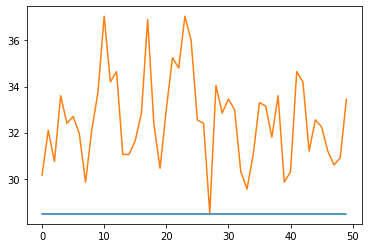

In [16]:
# Generate predictions
trainpred = model.predict(X_train)
testpred = model.predict(X_test)
print (trainpred.shape)
print (Y_train.shape)
plt.cla()
plt.plot(trainpred[:50])
plt.plot(Y_train[:50])
#plt.plot(testpred[:50,0:5])
plt.show()


In [9]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])
predictions = testpred

# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Train predictions
trainpredPlot = np.empty_like(dataset)
trainpredPlot[:, :] = np.nan
trainpredPlot[previous:len(trainpred)+previous, :] = trainpred

# Test predictions
testpredPlot = np.empty_like(dataset)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred)+(previous*2)+1:len(dataset)-1, :] = testpred

# Plot all predictions
inversetransform, =plt.plot(scaler.inverse_transform(dataset))
trainpred, =plt.plot(trainpredPlot)
testpred, =plt.plot(testpredPlot)
plt.xlabel('Days')
plt.ylabel('Kilowatt consumption (log)')
plt.title("Predicted vs. Actual Consumption")
plt.show()

NameError: name 'scaler' is not defined

In [ ]:
Y_test=np.exp(Y_test)
predictions=predictions.reshape(1,-1)
predictions=np.exp(predictions)

percentage_error=((predictions-Y_test)/Y_test)
percentage_error=abs(percentage_error)
mean=np.mean(percentage_error)
mean

In [ ]:
percentage_error=pd.DataFrame(percentage_error)
below10=percentage_error[percentage_error < 0.10].count()
all=percentage_error.count()
np.sum(below10)

In [ ]:
np.sum(all)